Epoch 10/50, Loss: 0.0
Epoch 20/50, Loss: 0.0
Epoch 30/50, Loss: 0.0
Epoch 40/50, Loss: 0.0
Epoch 50/50, Loss: 0.0


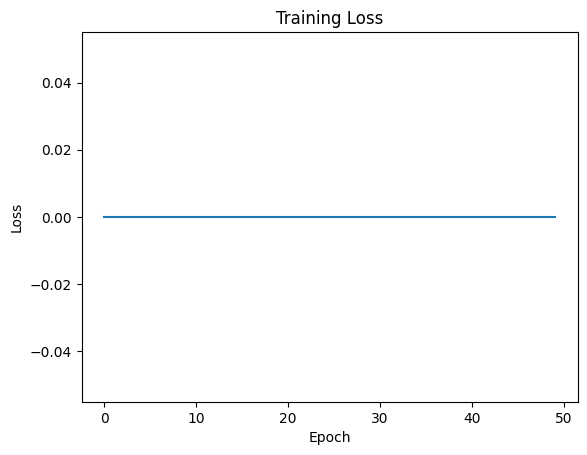

In [45]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sd.S_Mamba import Model

# Define a dummy configuration class
class Configs:
    def __init__(self):
        self.seq_len = 50  # Length of the input sequence
        self.pred_len = 10  # Length of the prediction sequence
        self.output_attention = False
        self.use_norm = False
        self.d_model = 16
        self.d_state = 8
        self.d_ff = 32
        self.e_layers = 4
        self.embed = 'fixed'
        self.freq = 'h'
        self.dropout = 0.1
        self.activation = 'relu'
        self.class_strategy = 'strategy'

# Initialize configurations
configs = Configs()

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model with the dummy configurations
model = Model(configs).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Generate cosine function data
def generate_cosine_data(seq_len, pred_len, num_samples):
    x = np.linspace(0, 2 * np.pi, seq_len + pred_len + num_samples - 1)
    data = .1*x
    # data = np.exp(20*x)
    dataset = []
    for i in range(num_samples):
        start = i
        sample_x_enc = data[start:start + seq_len]
        sample_x_dec = data[start + seq_len:start + seq_len + pred_len]
        sample_mark_enc = x[start:start + seq_len]
        sample_mark_dec = x[start + seq_len:start + seq_len + pred_len]
        dataset.append((sample_x_enc, sample_x_dec, sample_mark_enc, sample_mark_dec))
    return dataset

# Create the dataset
seq_len = configs.seq_len
pred_len = configs.pred_len
num_samples = 1
dataset = generate_cosine_data(seq_len, pred_len, num_samples)

# Training loop
num_epochs = 50
batch_size = 32

losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for i in range(0, len(dataset), batch_size):
        batch_data = dataset[i:i + batch_size]
        if len(batch_data) < batch_size:
            continue

        x_enc_batch = np.array([item[0] for item in batch_data])
        x_dec_batch = np.array([item[1] for item in batch_data])
        x_mark_enc_batch = np.array([item[2] for item in batch_data])
        x_mark_dec_batch = np.array([item[3] for item in batch_data])


        x_enc = torch.tensor(x_enc_batch, dtype=torch.float32).unsqueeze(-1).to(device)
        # x_mark_enc = torch.zeros_like(x_enc).to(device)  # Dummy temporal marks
        x_dec = torch.tensor(x_dec_batch, dtype=torch.float32).unsqueeze(-1).to(device)
        # x_mark_dec = torch.zeros_like(x_dec).to(device)  # Dummy temporal marks
        x_mark_enc = torch.tensor(x_mark_enc_batch, dtype=torch.float32).unsqueeze(-1).to(device)
        x_mark_dec = torch.tensor(x_mark_dec_batch, dtype=torch.float32).unsqueeze(-1).to(device)

        optimizer.zero_grad()
        output = model(x_enc, x_mark_enc)
        loss = criterion(output, x_dec)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    # print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(dataset)}')
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(dataset)}')

    
    losses.append(total_loss / len(dataset))

# Plot the loss curve
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()



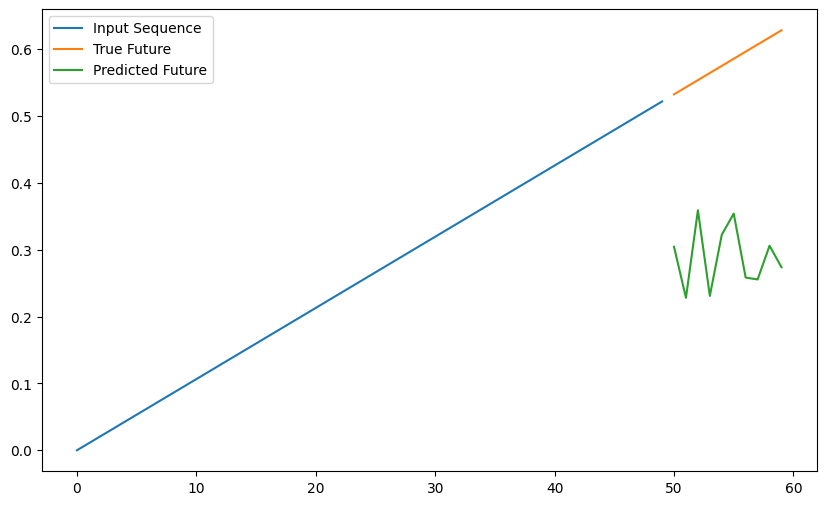

In [38]:
# Testing the model
model.eval()

with torch.no_grad():
    test_seq_len = configs.seq_len
    test_pred_len = configs.pred_len
    test_data = generate_cosine_data(test_seq_len, test_pred_len, 1)[0]

    test_x_enc = torch.tensor(test_data[0], dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
    # test_x_mark_enc = torch.zeros_like(test_x_enc).to(device)
    test_x_dec = torch.tensor(test_data[1], dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
    # test_x_mark_dec = torch.zeros_like(test_x_dec).to(device)

    test_x_mark_enc = torch.tensor(test_data[2], dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
    test_x_mark_dec = torch.tensor(test_data[3], dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)

    forecast = model(test_x_enc, test_x_mark_enc)
    # forecast = model(x_enc, x_mark_enc, x_dec, x_mark_dec)
    

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(range(seq_len), test_data[0], label='Input Sequence')
    plt.plot(range(seq_len, seq_len + pred_len), test_data[1], label='True Future')
    plt.plot(range(seq_len, seq_len + pred_len), forecast.cpu().numpy().flatten(), label='Predicted Future')
    plt.legend()
    plt.show()